In [1]:
#!pip install tta_wrapper --user

In [2]:
import os
import sys

os.environ['CUDA_VISIBLE_DEVICES'] = '2'
sys.path.append('..')

In [3]:
from keras.models import load_model

Using TensorFlow backend.


In [4]:
### Functions
import numpy as np


def get_shape(x, split_size, overlap):
    """
    Calculate shape `X` nearest, but bigger than `x` by `split_size` and `overlap`:
        `X = split_size * n - overlap * (n - 1)`, where `n` is integer 
        
    Args:
        x (int): size 
        split_size (int): segment lenght
        overlap (int): number of pixels shareable between neighbour segments
    
    Return:
        x (int): suitable shape 
    """
    if x <= split_size - overlap:
        return split_size 
    elif x <= split_size:
        x += overlap
        
    size = split_size - overlap
    x_ = x - overlap
    x = (x_ // size + 1) * size + overlap
    return x

            
def pad(image, divisible_by=128):
    """
    Add additional pixels to image to make it divisible by provided number
    
    Args:
        image (numpy.ndarray): 2d or 3d numpy.ndarray (n_rows x n_cols x n_channels)
         (int): size of tiles in pixels, should be 2^n and 
         divisible_by (int): number of pixels
            
    Return:
        image (numpy.ndarray): image with shape divisible by provided number
        paddings (list of tuples): numbers of pixels added on each side
            ((padding_top, padding_bottom), (padding_left, padding_right), (...)) 
        
    """
    h, w = image.shape[:2]

    func = lambda x:(divisible_by - x % divisible_by) / 2
    
    pad_h_top = np.floor(func(h)).astype(np.int_)
    pad_h_bot = np.ceil(func(h)).astype(np.int_)
    pad_w_left = np.floor(func(w)).astype(np.int_)
    pad_w_right = np.ceil(func(w)).astype(np.int_)

    paddings = ((pad_h_top, pad_h_bot), 
                (pad_w_left, pad_w_right), 
                (0,0))

    if image.ndim == 2:
        image = np.expand_dims(image, axis=-1)

    image = np.pad(image, paddings, mode='reflect')

    return image, paddings


def pad_shape(image, shape):
    """
    Add additional pixels to image to make it provided shape
    
    Args:
        image (numpy.ndarray): 2d or 3d numpy.ndarray (n_rows x n_cols x n_channels)
        shape (tuple of int): size of output image
            
    Return:
        image (numpy.ndarray): image with `shape`
        paddings (list of tuples): numbers of pixels added on each side
            ((padding_top, padding_bottom), (padding_left, padding_right), (...)) 
        
    """
        
    h, w = image.shape[:2]
    target_h, target_w = shape
    
    assert target_h > h
    assert target_w > w
    
    pad_h_top = int(np.floor((target_h - h)/2))
    pad_h_bot = int(np.ceil((target_h - h)/2))
    pad_w_left = int(np.floor((target_w - w)/2))
    pad_w_right = int(np.ceil((target_w - w)/2))

    paddings = ((pad_h_top, pad_h_bot), 
                (pad_w_left, pad_w_right), 
                (0,0))

    if image.ndim == 2:
        image = np.expand_dims(image, axis=-1)

    image = np.pad(image, paddings, mode='reflect')

    return image, paddings


def unpad(image, paddings):
    """ 
    Delete paddings on picture
    
    Args:
        image (numpy.ndarray): 2d or 3d numpy.ndarray (n_rows x n_cols x n_channels)
        paddings (list of tuples): numbers of pixels to be deleted on each side
            ((padding_top, padding_bottom), (padding_left, padding_right), (...)) 
        
    Return:
        image (numpy.ndarray): cropped image
    """
    h, w = image.shape[:2]

    h_top, h_bot = paddings[0]
    w_left, w_right = paddings[1]

    image = image[h_top:h-h_bot, w_left:w-w_right]

    return image        
           


def split(image, split_size=1024):
    """
    Split image to tiles of size `split_size x split_size` and return list of them
    
    Args:
        image (numpy.ndarray): 2d or 3d numpy.ndarray (n_rows x n_cols x n_channels)
        split_size (int): size of tiles in pixels, should be 2^n and 
            image`s width and height should be divisible by split_size
            
    Return:
        images (list of numpy.ndarray): list of tiles of size `split_size x split_size`
        n_rows, n_cols (int): number of rows and cols to reconstruct original image,
            `n_rows * n_cols` equal to number of images
    """
    h, w = image.shape[:2]

    assert h % split_size == 0
    assert w % split_size == 0

    n_rows = h // split_size
    n_cols = w // split_size

    h_size = h // n_rows
    w_size = w // n_cols

    ws = np.linspace(0, h, n_rows+1).astype(np.int_)[:-1]
    hs = np.linspace(0, w, n_cols+1).astype(np.int_)[:-1]

    images = []

    for h_ in hs:
        for w_ in ws:
            crop_image = image[h_:h_+h_size, w_:w_+w_size]
            images.append(crop_image)

    return images, n_rows, n_cols


def overlap_split(image, split_size, overlap):
    """
    Split image to tiles of size `split_size x split_size` and return list of them.
    To make percise splitting images shapes should be divisible by `split_size`
    
    Args:
        image (numpy.ndarray): 2d or 3d numpy.ndarray (n_rows x n_cols x n_channels)
        split_size (int): size of tiles in pixels, should be 2^n and 
            image`s width and height should be divisible by split_size
        overlap (int): number of pixels shareable between neighbour tiles
            
    Return:
        images (list of numpy.ndarray): list of tiles of size `split_size x split_size`
        n_rows, n_cols (int): number of rows and cols to reconstruct original image,
            `n_rows * n_cols` equal to number of images
    """
    
    h, w = image.shape[:2]
    
    n_rows = int((h - overlap) / (split_size - overlap))
    n_cols = int((w - overlap) / (split_size - overlap))

    w_size = split_size - overlap
    h_size = split_size - overlap

    images = []

    for i in range(n_rows):
        h_ = i * h_size
        for j in range(n_cols):
            w_ = j * w_size
            crop_image = image[h_:h_+split_size, w_:w_+split_size]
            images.append(crop_image)

    return images, n_rows, n_cols


def concatenate(images, n_rows, n_cols):
    """
    Concatenate list of images into ine big image according to number of rows and colums
    
    Args:
        images (list of numpy.ndarray): list of images(tiles) - 2d or 3d arrays with same shape
        n_rows, n_cols (int): number of rows and cols to reconstruct original image,
            `n_rows * n_cols` should be equal to number of images
    Return:
        image (numpy.ndarray): reconstructed image with shape tile_height*n_rows, tile_widht*n_cols
    
    """

    assert len(images) == n_rows * n_cols

    rows = []

    for i in range(n_rows):
        row = np.concatenate(images[i*n_cols:(i+1)*n_cols], axis=1)
        rows.append(row)

    img = np.concatenate(rows, axis=0)

    return img


def overlap_concatenate(images, n_rows, n_cols, overlap):
    """
    Concatenate list of images into ine big image according to number of rows and colums
    
    Args:
        images (list of numpy.ndarray): list of images(tiles) - 2d or 3d arrays with same shape
        n_rows, n_cols (int): number of rows and cols to reconstruct original image,
            `n_rows * n_cols` should be equal to number of images
        overlap (int): number of pixels shareable between neighbour tiles
        
    Return:
        image (numpy.ndarray): reconstructed image with shape
            `image_width = tile_width * n_cols - overlap * (n_cols - 1)`
            `image_height = tile_height * n_rows - overlap * (n_rows - 1)`
    
    """
    crop_images = []
    for i in range(n_rows):
        for j in range(n_cols):
            index = i*n_cols+j
            
            h_pad_top = overlap // 2 if i!=0 else 0
            h_pad_bot = overlap // 2 if i!=n_rows-1 else 0
            w_pad_left = overlap // 2 if j!=0 else 0
            w_pad_right = overlap // 2 if j!=n_cols-1 else 0
            
            paddings = ((h_pad_top, h_pad_bot),
                       (w_pad_left, w_pad_right),
                       (0,0))
            
            img = unpad(images[index], paddings)
            crop_images.append(img)
    
    image = concatenate(crop_images, n_rows, n_cols)
    
    return image



In [5]:
def predict(image, model, split_size=1024, overlap=64):

    h, w = image.shape[:2]

    h = get_shape(h, split_size, overlap)
    w = get_shape(w, split_size, overlap)

    print('splitting...', end='')
    image, paddings = pad_shape(image, (h, w))
    images, n_rows, n_cols = overlap_split(image, split_size, overlap)

    predictions = []

    print('processing...')

    for image in images:
        image = np.expand_dims(image, axis=0)  # input image have to be 4d tensor
        pred = model.predict(image)
        pred = np.squeeze(pred)
        predictions.append(pred)

    print('merging tiles...', end='')

    if len(predictions) > 1:
        prediction = overlap_concatenate(predictions, n_rows, n_cols, overlap)
    else:
        prediction = np.squeeze(predictions)
    prediction = unpad(prediction, paddings)
    print('done!')
    return prediction

### Loading model

In [6]:
from tta_wrapper import tta_segmentation

In [7]:
model = load_model('../../checkpoints/exp-5/ep_31-score_0.4565.h5', compile=False)

In [8]:
tta_model = tta_segmentation(model, h_flip=True, v_flip=True)

### Loading data

In [21]:
LOAD_DIR = '../../data/dataset/train/images/'
SAVE_DIR = '../../data/predictions/test_1/images/exp-5/'
os.makedirs(SAVE_DIR, exist_ok=True)

In [10]:
import cv2

def read_image(path):
    return cv2.imread(path)[..., ::-1].copy()

def save_mask(path, image):
    cv2.imwrite(path, image * 255)

In [22]:
for id in os.listdir(LOAD_DIR):
    
    src_path = os.path.join(LOAD_DIR, id)
    image = read_image(src_path)
    
    pred = predict(image, model).squeeze()
    
    dst_path = os.path.join(SAVE_DIR, id)
    save_mask(dst_path, pred)

splitting...processing...
merging tiles...done!
splitting...processing...
merging tiles...done!
splitting...processing...
merging tiles...done!
splitting...processing...
merging tiles...done!
splitting...processing...
merging tiles...done!
splitting...processing...
merging tiles...done!
splitting...processing...
merging tiles...done!
splitting...processing...
merging tiles...done!
splitting...processing...
merging tiles...done!
splitting...processing...
merging tiles...done!


### Visualization

In [23]:
import matplotlib.pyplot as plt

In [24]:
def add_mask(image, mask, channel='r', intensity=100):

        r, g, b = image.transpose(2,0,1)
        mask = mask.squeeze() * intensity

        if channel == 'r':
            r = r.astype(np.uint16) + mask.astype(np.uint16)
            r = np.clip(r, 0, 255).astype(np.uint8)

        if channel == 'g':
            g = g.astype(np.uint16) + mask.astype(np.uint16)
            g = np.clip(g, 0, 255).astype(np.uint8)

        if channel == 'b':
            b = b.astype(np.uint16) + mask.astype(np.uint16)
            b = np.clip(b, 0, 255).astype(np.uint8)

        image = np.stack((r, g, b)).transpose(1,2,0)

        return image

image_1 = add_mask(image, pred, channel='b', intensity=255)

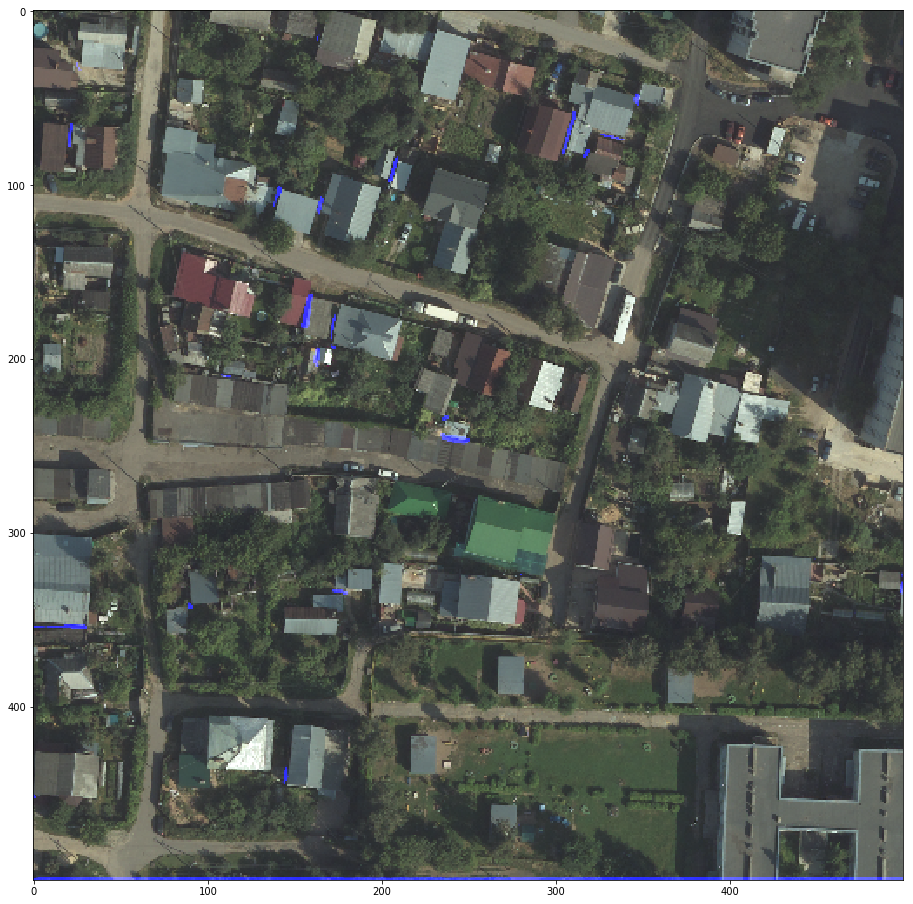

In [25]:
plt.figure(figsize=(16, 16))
plt.imshow(image_1[-2000::4, -2000::4])
plt.show()

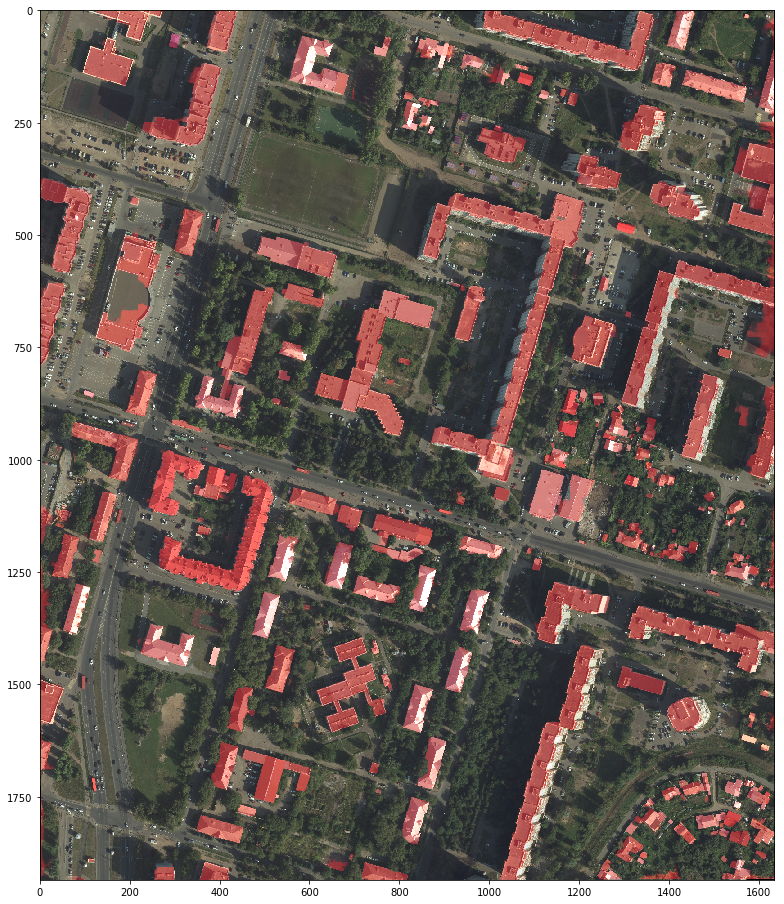

In [16]:
plt.figure(figsize=(16, 16))
plt.imshow(image_1[::4, ::4])
plt.show()